In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [6]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [7]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.56829617])

In [8]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [9]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.419967
 stars         0.413894
 quixotic      0.072241
 merciful      0.056910
 fireman       0.032434
 wrap          0.000407
 clammy        0.000383
 change        0.000306
 lip           0.000299
 touch         0.000281
 adhesive      0.000253
 playground    0.000235
 sweltering    0.000233
 offer         0.000232
 rigid         0.000217
 shelf         0.000208
 barbarous     0.000192
 damp          0.000192
 rain          0.000184
 dependent     0.000180
 nonchalant    0.000171
 lethal        0.000159
 cute          0.000154
 eight         0.000138
 future        0.000131
 dtype: float64}

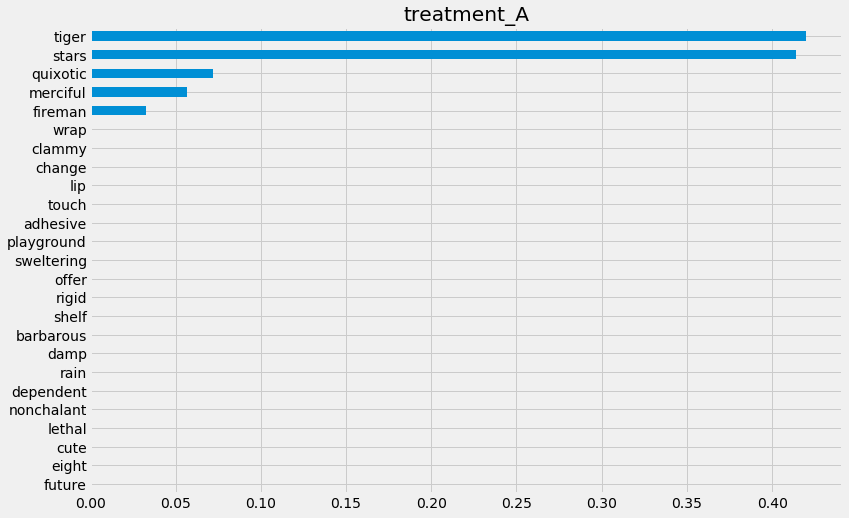

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [11]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.963026
 stars         0.869475
 quixotic      0.163553
 merciful      0.101724
 fireman       0.065210
 touch         0.000389
 clammy        0.000370
 adhesive      0.000180
 wrap          0.000150
 sweltering    0.000144
 change        0.000104
 lethal        0.000095
 damp          0.000071
 shelf         0.000040
 rigid         0.000028
 barbarous     0.000026
 playground    0.000021
 nonchalant   -0.000014
 cute         -0.000020
 rain         -0.000034
 offer        -0.000046
 eight        -0.000054
 dependent    -0.000060
 future       -0.000091
 lip          -0.000097
 dtype: float64}

In [12]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 37.788124799728394 seconds


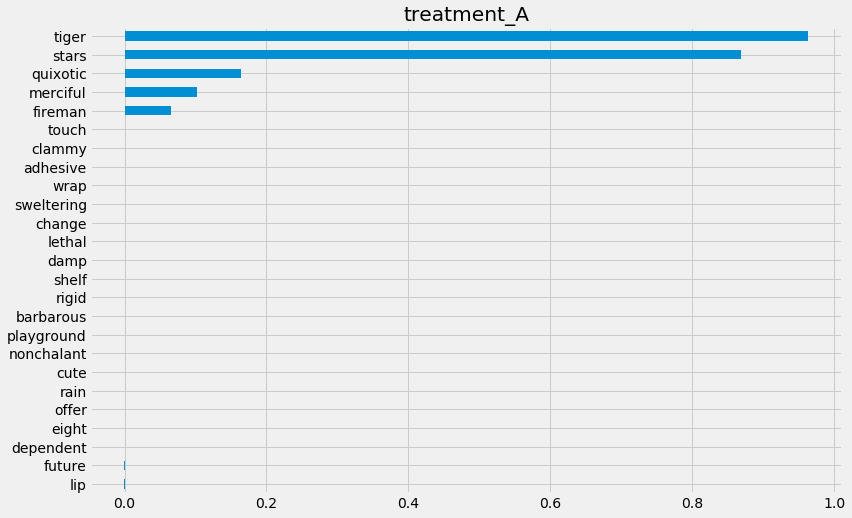

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [14]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 14.822510957717896 seconds


In [15]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.963026
stars         0.869475
quixotic      0.163553
merciful      0.101724
fireman       0.065210
touch         0.000389
clammy        0.000370
adhesive      0.000180
wrap          0.000150
sweltering    0.000144
change        0.000104
lethal        0.000095
damp          0.000071
shelf         0.000040
rigid         0.000028
barbarous     0.000026
playground    0.000021
nonchalant   -0.000014
cute         -0.000020
rain         -0.000034
offer        -0.000046
eight        -0.000054
dependent    -0.000060
future       -0.000091
lip          -0.000097
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

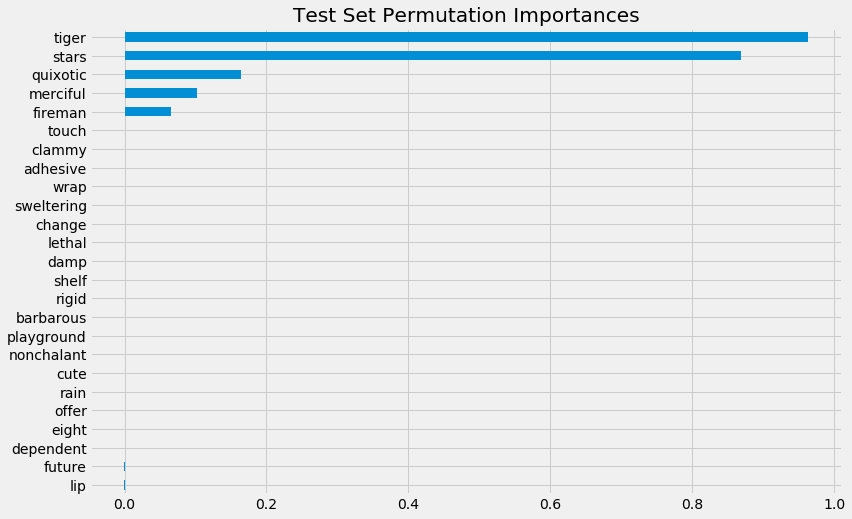

In [16]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [17]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

tiger         0.912573
stars         0.871412
quixotic      0.164476
merciful      0.104541
fireman       0.064374
lip           0.001931
lethal        0.001112
future        0.001104
clammy        0.000977
touch         0.000935
damp          0.000868
wrap          0.000868
change        0.000824
sweltering    0.000806
adhesive      0.000732
offer         0.000690
rain          0.000652
barbarous     0.000525
rigid         0.000492
eight         0.000458
dependent     0.000438
cute          0.000419
nonchalant    0.000405
shelf         0.000400
playground    0.000354
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

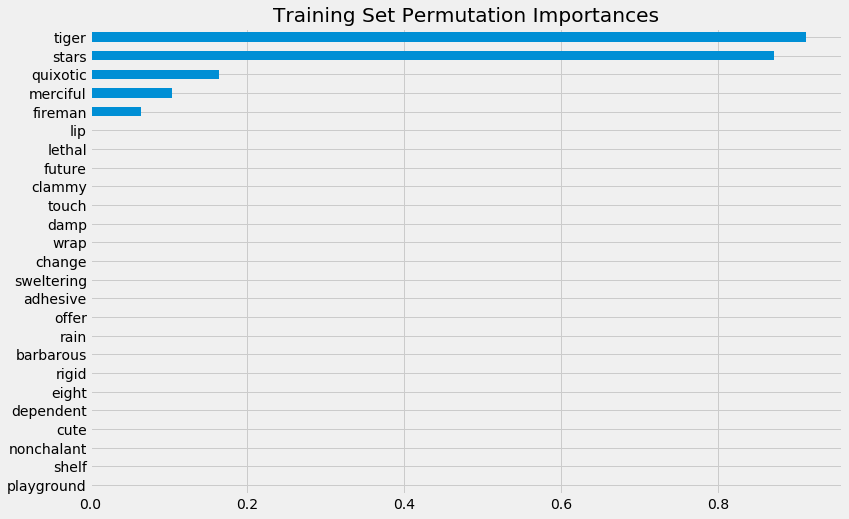

In [18]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 4.10078017e-02, -3.44817262e-02, -5.43404776e-03, ...,
         -4.74545331e-04, -1.51053586e-03,  3.90095411e-03],
        [-7.48726271e-02,  5.93780768e-02, -1.41883322e-02, ...,
          7.46974369e-04, -4.48063259e-04, -1.89122689e-03],
        [ 8.76198804e-02, -1.16128067e-02,  4.81884470e-03, ...,
         -4.35674464e-04,  1.93345867e-03,  3.70921426e-03],
        ...,
        [ 1.97191229e-01,  1.04795472e-01,  6.66297704e-03, ...,
         -4.94229406e-04,  1.23164980e-03, -1.94624556e-03],
        [-2.51788728e-01,  1.66874562e-02,  3.63517776e-02, ...,
         -4.77522143e-04,  1.13078435e-03,  1.69601440e-03],
        [-3.20539506e-02,  2.13426166e-01, -7.80250031e-02, ...,
         -1.84885894e-04,  1.69764654e-04, -3.78072076e-03]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.13950704, 0.14386761, 0.02545777, 0.04069884, 0.02323508,
       0.00065427, 0.00049449, 0.00085658, 0.00047613, 0.00106313,
       0.00039083, 0.00039238, 0.0004238 , 0.00033561, 0.00080356,
       0.00035307, 0.00024251, 0.0008808 , 0.00035521, 0.00104124,
       0.00022112, 0.00119311, 0.00060483, 0.00089334, 0.00178355])

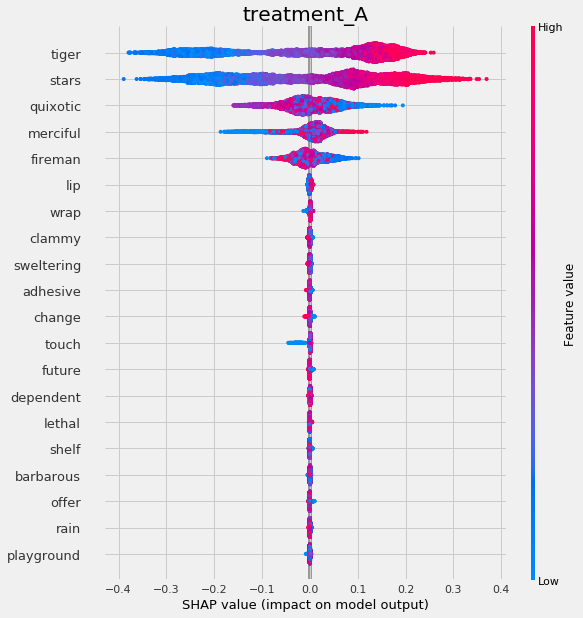

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

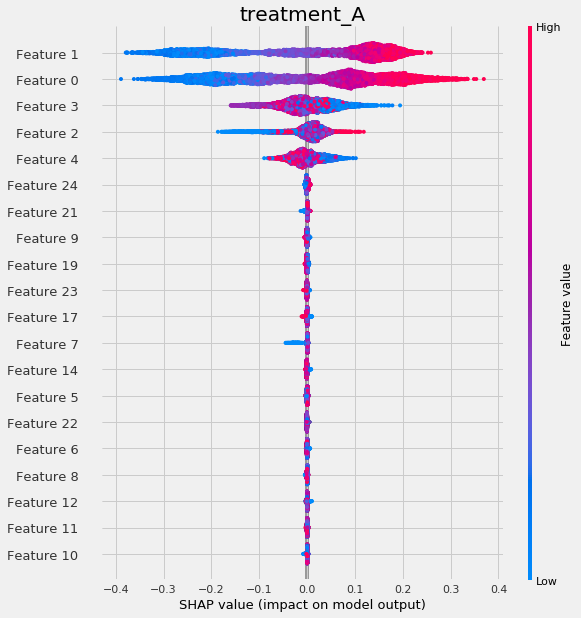

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

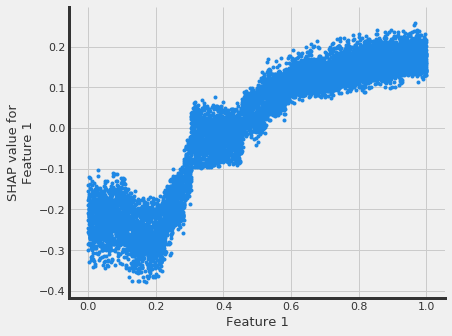

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

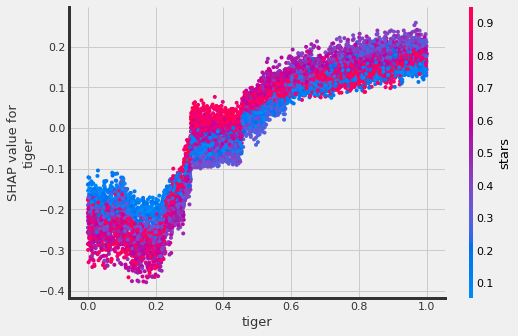

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

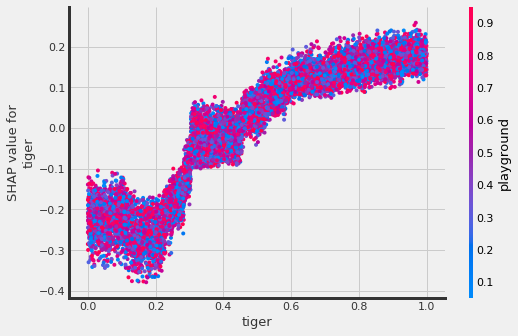

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [26]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.5526554]), array([0.53763828]), array([0.56767251]))

In [27]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [28]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.329522
 stars         0.319934
 quixotic      0.066615
 merciful      0.043139
 fireman       0.039397
 wrap          0.015105
 offer         0.013031
 touch         0.012786
 future        0.012633
 clammy        0.012428
 damp          0.011408
 dependent     0.011313
 adhesive      0.010930
 change        0.010475
 rain          0.010393
 cute          0.009622
 rigid         0.009564
 barbarous     0.009170
 nonchalant    0.009108
 eight         0.008167
 sweltering    0.007606
 lip           0.007596
 shelf         0.007189
 lethal        0.006894
 playground    0.005973
 dtype: float64}

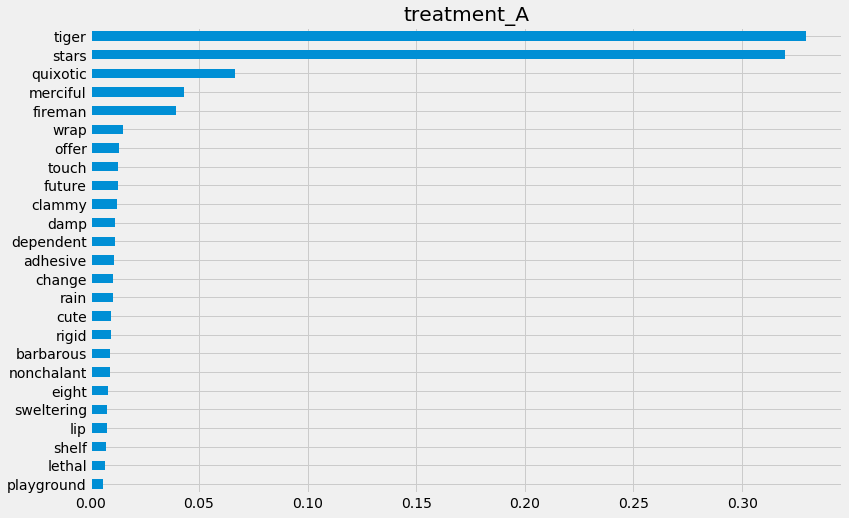

In [29]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [30]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.538136
 stars         0.510393
 quixotic      0.072974
 merciful      0.038492
 fireman       0.037728
 wrap          0.012041
 offer         0.008361
 future        0.007785
 clammy        0.006456
 adhesive      0.006216
 dependent     0.006018
 touch         0.005865
 damp          0.005544
 nonchalant    0.005190
 sweltering    0.005030
 rain          0.004813
 cute          0.004293
 change        0.004053
 lip           0.003858
 rigid         0.003853
 shelf         0.003634
 eight         0.003334
 barbarous     0.002836
 lethal        0.002367
 playground    0.000314
 dtype: float64}

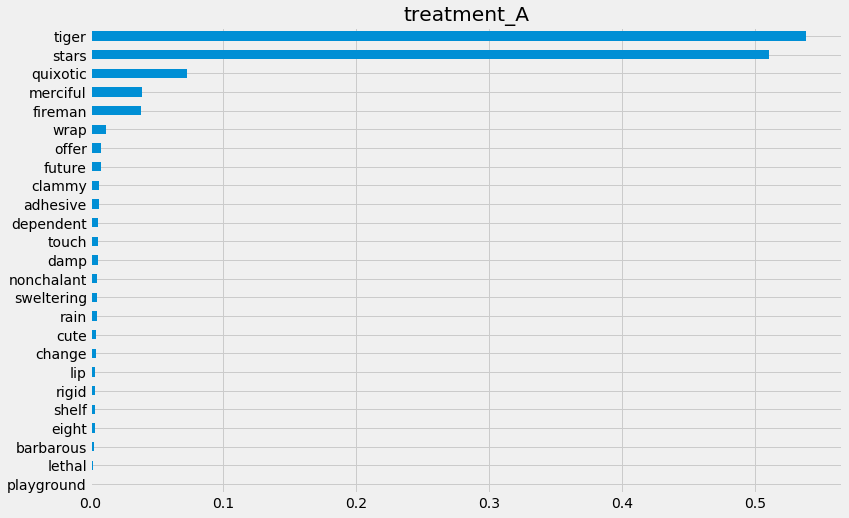

In [31]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [32]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 16.60052752494812 seconds


In [33]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.538136
stars         0.510393
quixotic      0.072974
merciful      0.038492
fireman       0.037728
wrap          0.012041
offer         0.008361
future        0.007785
clammy        0.006456
adhesive      0.006216
dependent     0.006018
touch         0.005865
damp          0.005544
nonchalant    0.005190
sweltering    0.005030
rain          0.004813
cute          0.004293
change        0.004053
lip           0.003858
rigid         0.003853
shelf         0.003634
eight         0.003334
barbarous     0.002836
lethal        0.002367
playground    0.000314
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

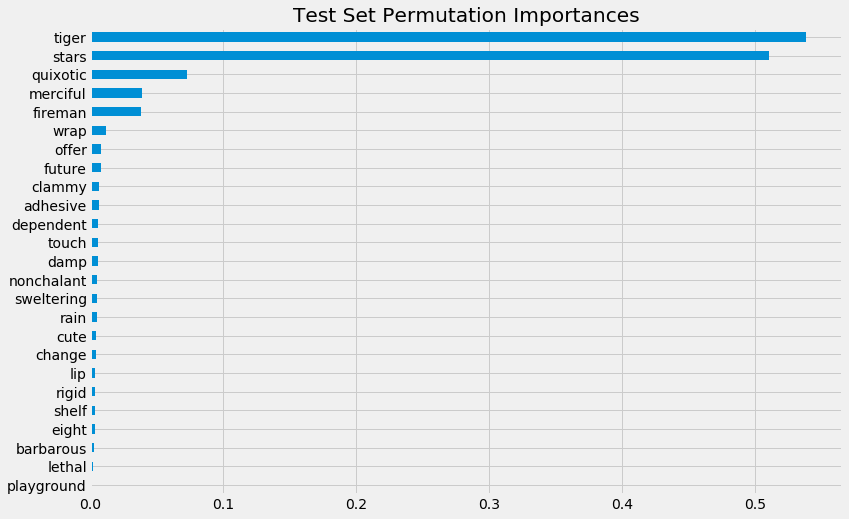

In [34]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [35]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[ 0.03170431, -0.02653401, -0.04181033, ..., -0.00420727,
         -0.00209201,  0.0116853 ],
        [-0.09827316,  0.02655629, -0.02626074, ..., -0.00074733,
          0.00907333,  0.0007965 ],
        [ 0.05350246, -0.01205391,  0.00787274, ...,  0.00092083,
          0.01316705,  0.01219494],
        ...,
        [ 0.29451126,  0.07890184, -0.00674396, ..., -0.003012  ,
          0.01859159, -0.0096335 ],
        [-0.2375042 , -0.00485028, -0.00101973, ...,  0.00079727,
          0.01883852,  0.00980794],
        [-0.05199902,  0.1479534 , -0.09951596, ...,  0.01449447,
          0.01699256, -0.01394553]])}

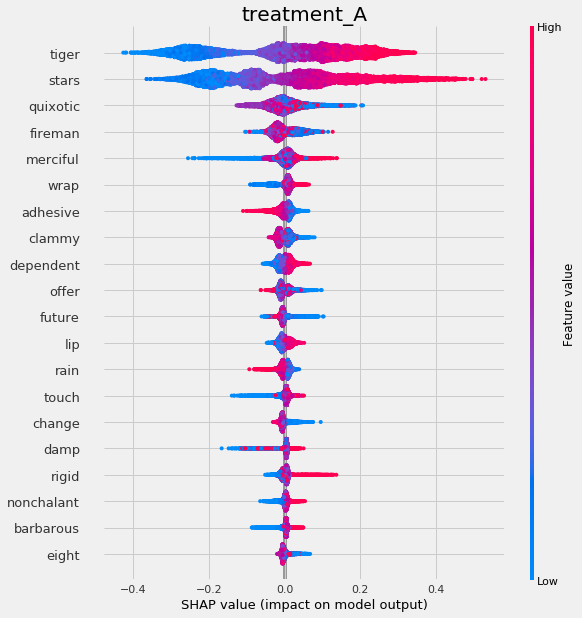

In [36]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

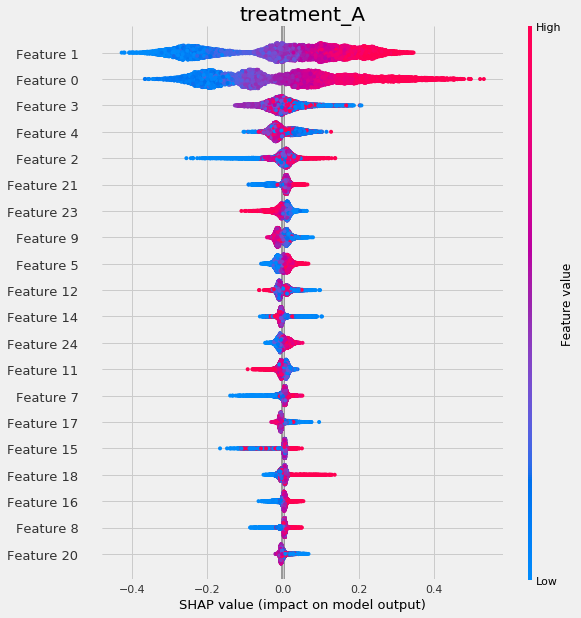

In [37]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

## X Learner

In [38]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

(array([0.51497605]), array([0.50079629]), array([0.52915581]))

In [39]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [40]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.396410
 tiger         0.387525
 merciful      0.023992
 quixotic      0.020416
 wrap          0.013560
 future        0.012550
 fireman       0.012385
 dependent     0.012259
 adhesive      0.010841
 rain          0.009530
 clammy        0.009327
 offer         0.008513
 lip           0.008454
 touch         0.008432
 rigid         0.008281
 damp          0.007743
 shelf         0.007601
 nonchalant    0.007137
 barbarous     0.006748
 eight         0.006329
 cute          0.005616
 lethal        0.004837
 change        0.004130
 sweltering    0.004092
 playground    0.003290
 dtype: float64}

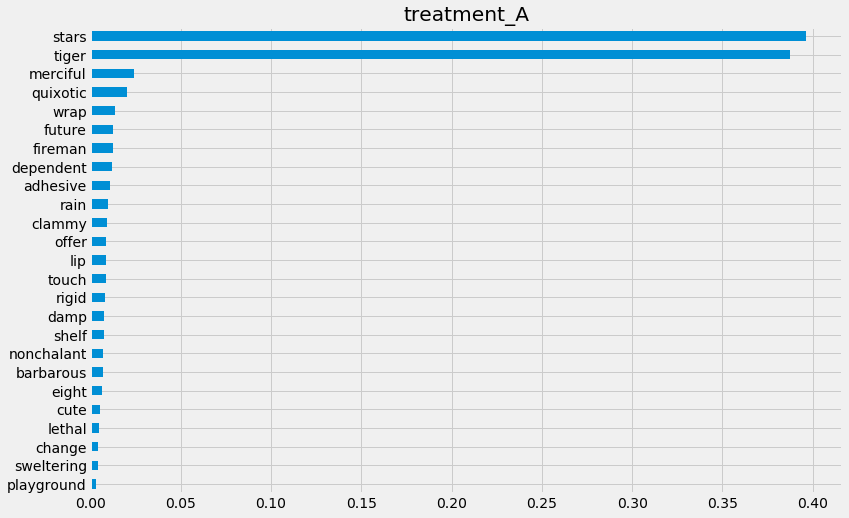

In [41]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [42]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': stars         0.759553
 tiger         0.745122
 merciful      0.031355
 quixotic      0.027350
 dependent     0.018033
 fireman       0.017579
 future        0.015751
 wrap          0.015741
 adhesive      0.011913
 rain          0.011430
 lip           0.010565
 clammy        0.010158
 offer         0.008963
 shelf         0.007556
 touch         0.007548
 damp          0.006499
 barbarous     0.006480
 rigid         0.006472
 nonchalant    0.006457
 lethal        0.006313
 eight         0.004812
 cute          0.004193
 change        0.003709
 sweltering    0.003384
 playground    0.001421
 dtype: float64}

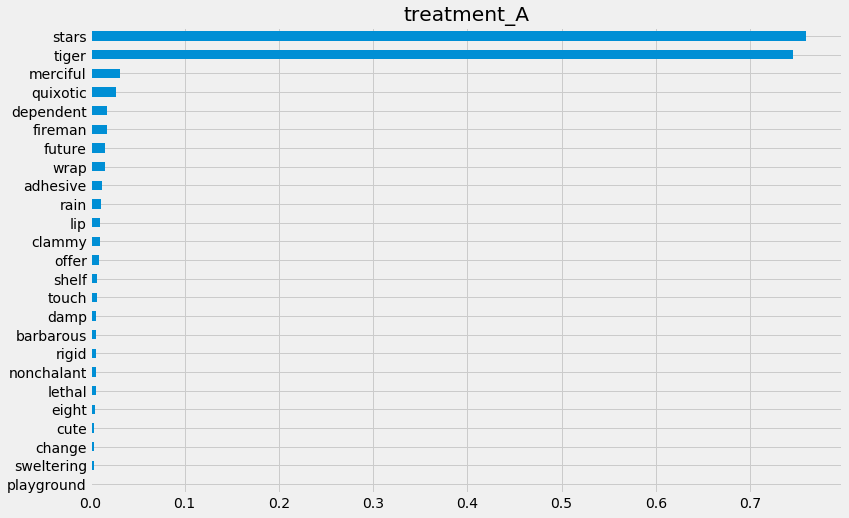

In [43]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [44]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 13.757911920547485 seconds


In [45]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.759553
tiger         0.745122
merciful      0.031355
quixotic      0.027350
dependent     0.018033
fireman       0.017579
future        0.015751
wrap          0.015741
adhesive      0.011913
rain          0.011430
lip           0.010565
clammy        0.010158
offer         0.008963
shelf         0.007556
touch         0.007548
damp          0.006499
barbarous     0.006480
rigid         0.006472
nonchalant    0.006457
lethal        0.006313
eight         0.004812
cute          0.004193
change        0.003709
sweltering    0.003384
playground    0.001421
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

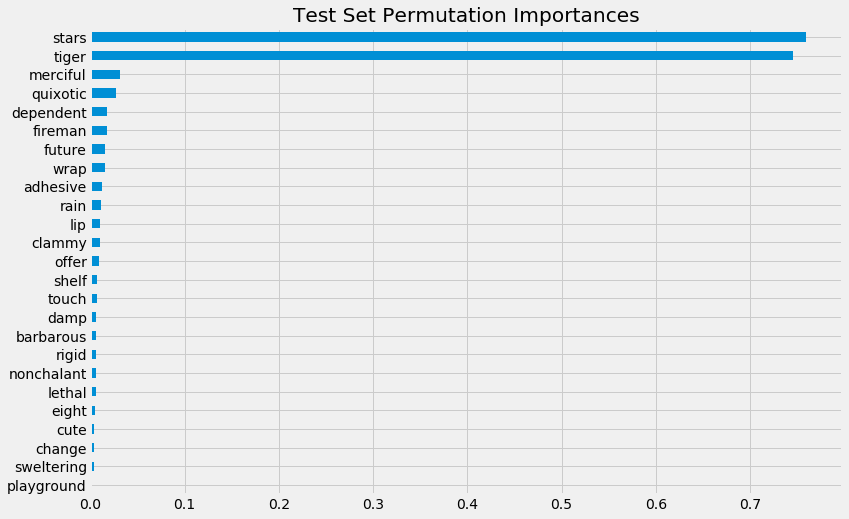

In [46]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [47]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[ 0.05905145, -0.01813719, -0.00228681, ...,  0.00163275,
          0.000808  ,  0.01982337],
        [-0.09223067,  0.03460351, -0.00243063, ..., -0.00886324,
          0.00251886, -0.00680032],
        [ 0.07817859, -0.01975654,  0.00473035, ..., -0.00076119,
          0.0218636 ,  0.01243895],
        ...,
        [ 0.30115384,  0.09553369, -0.00154573, ..., -0.00331466,
          0.00920979, -0.0128445 ],
        [-0.21004379, -0.03674163, -0.00241997, ...,  0.00449733,
          0.01845317,  0.01552738],
        [-0.11479351,  0.06604962, -0.14693142, ...,  0.00789741,
          0.00943036, -0.01086603]])}

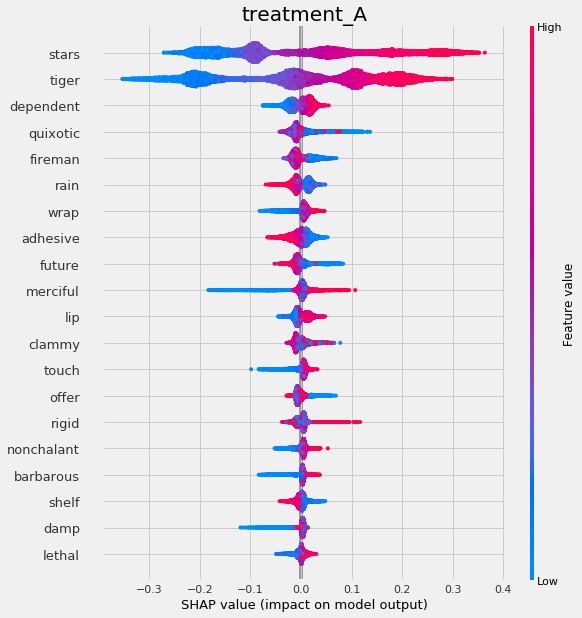

In [48]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

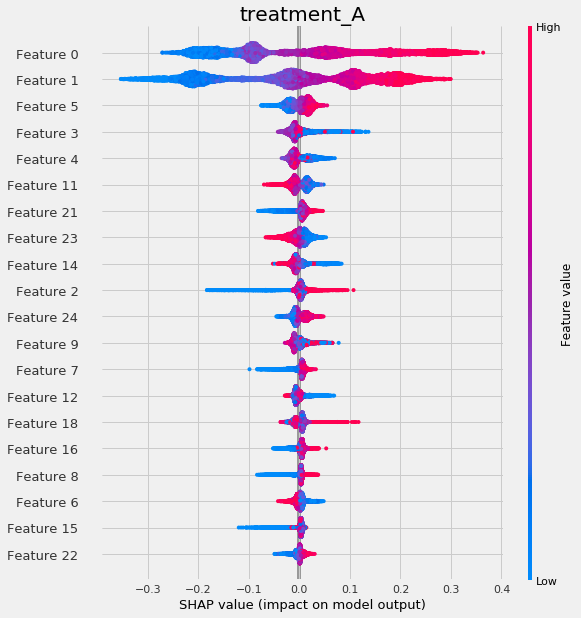

In [49]:
# shap_dict specified
xlearner.plot_shap_values(X=X, shap_dict=shap_xlearner)

## R Learner

In [50]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [51]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.228704
 tiger         0.225389
 barbarous     0.039622
 future        0.033504
 wrap          0.032853
 quixotic      0.030002
 touch         0.029991
 damp          0.028726
 fireman       0.027299
 dependent     0.027245
 offer         0.026600
 shelf         0.025857
 merciful      0.024646
 lethal        0.022051
 clammy        0.021187
 rigid         0.020775
 nonchalant    0.020411
 change        0.019242
 eight         0.018544
 sweltering    0.018139
 rain          0.018029
 adhesive      0.016737
 cute          0.016656
 playground    0.014999
 lip           0.012792
 dtype: float64}

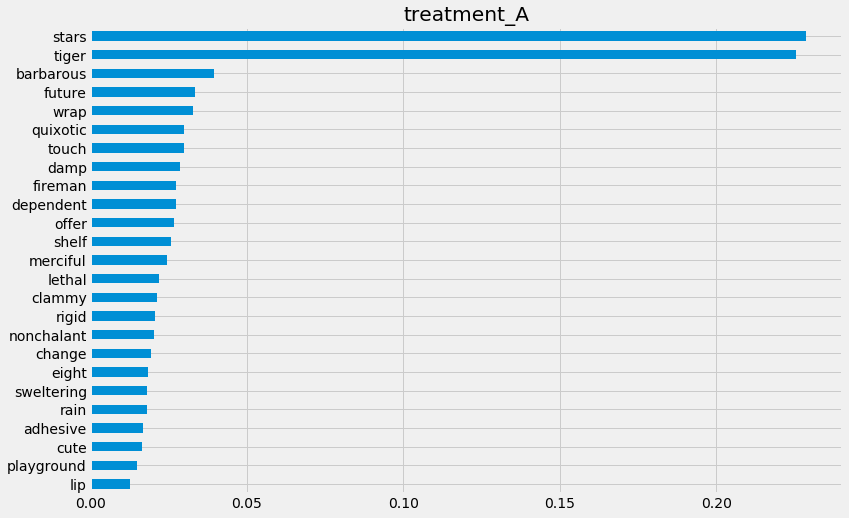

In [63]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [64]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.333106
 stars         0.317470
 barbarous     0.030943
 future        0.026448
 wrap          0.023439
 quixotic      0.022111
 merciful      0.018122
 offer         0.017440
 clammy        0.015891
 touch         0.015746
 fireman       0.015017
 shelf         0.013932
 damp          0.013886
 dependent     0.013519
 rain          0.013181
 adhesive      0.012412
 eight         0.010187
 sweltering    0.010025
 rigid         0.008814
 lethal        0.008810
 playground    0.008513
 nonchalant    0.008323
 change        0.006865
 lip           0.005458
 cute          0.004243
 dtype: float64}

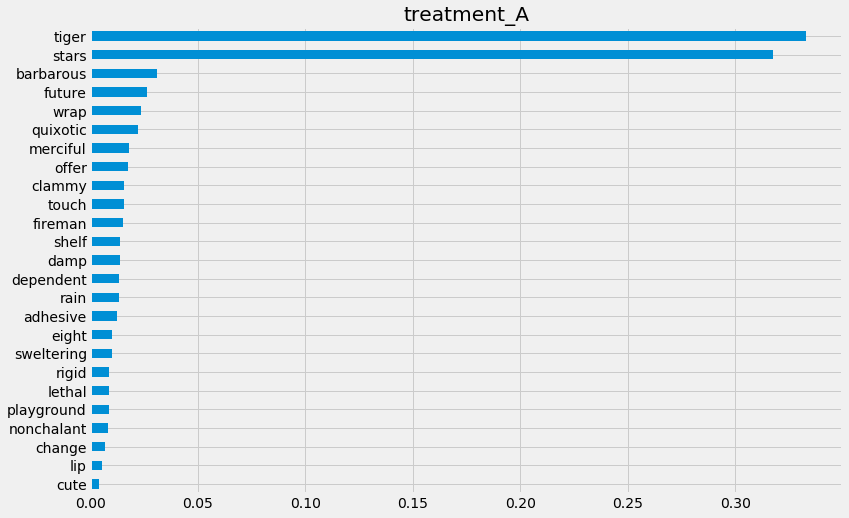

In [65]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [66]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 90.21177053451538 seconds


In [67]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.333106
stars         0.317470
barbarous     0.030943
future        0.026448
wrap          0.023439
quixotic      0.022111
merciful      0.018122
offer         0.017440
clammy        0.015891
touch         0.015746
fireman       0.015017
shelf         0.013932
damp          0.013886
dependent     0.013519
rain          0.013181
adhesive      0.012412
eight         0.010187
sweltering    0.010025
rigid         0.008814
lethal        0.008810
playground    0.008513
nonchalant    0.008323
change        0.006865
lip           0.005458
cute          0.004243
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

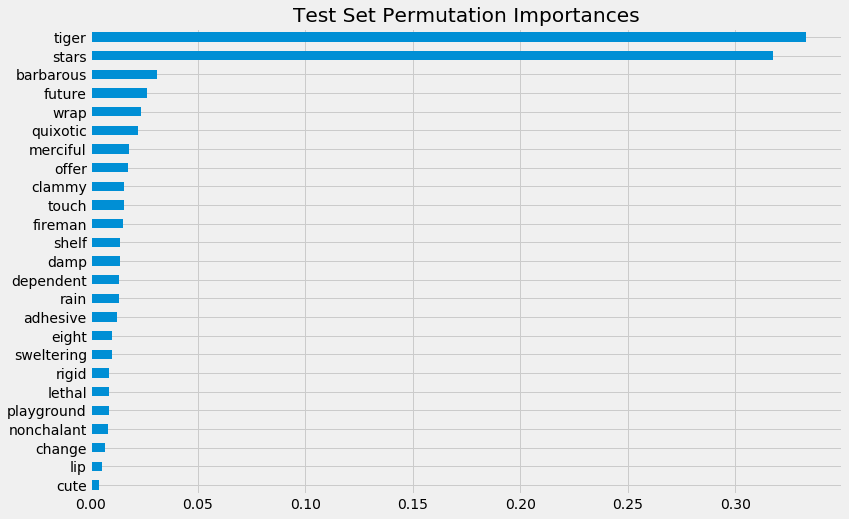

In [68]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [69]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[ 0.03538328, -0.01669669, -0.00440836, ..., -0.00239448,
          0.00593215,  0.01938478],
        [-0.10946828,  0.04119494, -0.00412831, ..., -0.00789067,
          0.01280531, -0.00584103],
        [ 0.05171293, -0.00447188,  0.00395468, ..., -0.00422879,
          0.00992719,  0.00150335],
        ...,
        [ 0.31724012,  0.07934517,  0.00141576, ..., -0.0094692 ,
          0.0169413 , -0.03495447],
        [-0.20257113, -0.03005302, -0.00690099, ..., -0.00055628,
          0.02064072,  0.0141801 ],
        [-0.07420896,  0.10717246, -0.04564806, ...,  0.01367809,
          0.01263303, -0.01483177]])}

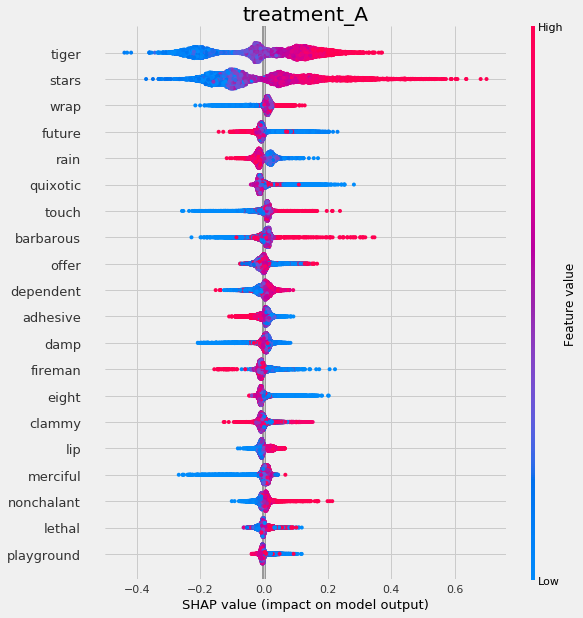

In [70]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

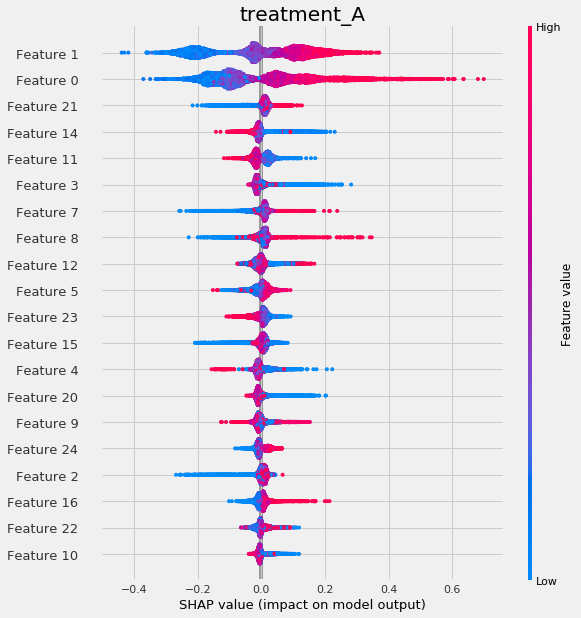

In [71]:
# with providing shap_dict
rlearner.plot_shap_values(X=X, shap_dict=shap_rlearner)

# Uplift Tree/Forest

Note that uplift trees/forests are only implemented for classification at the moment, hence the following section uses a different synthetic data generation process.

### UpliftTreeClassifier

In [61]:
from causalml.dataset import make_uplift_classification

df, x_names = make_uplift_classification()

In [62]:
uplift_tree = UpliftTreeClassifier(control_name='control')

uplift_tree.fit(X=df[x_names].values,
                treatment=df['treatment_group_key'].values,
                y=df['conversion'].values)

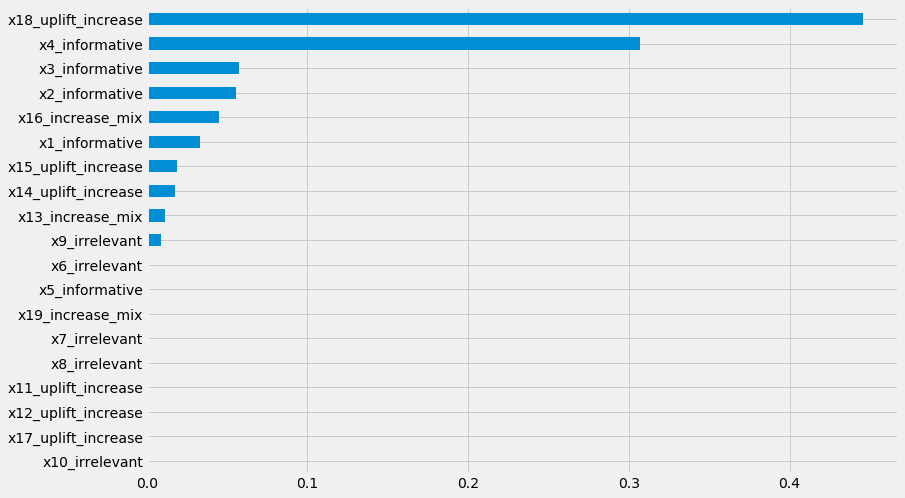

In [63]:
pd.Series(uplift_tree.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

### UpliftRandomForestClassifier

In [64]:
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=df[x_names].values,
              treatment=df['treatment_group_key'].values,
              y=df['conversion'].values)

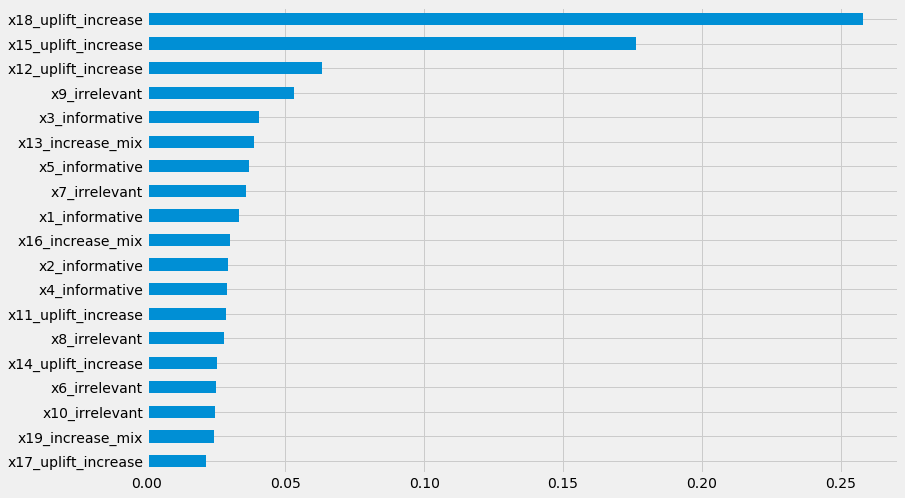

In [65]:
pd.Series(uplift_rf.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))